# Fish Classification - CNN Model Training

This notebook trains **6 different CNN models**:

1. **Custom CNN** - Simple baseline model built from scratch
2. **VGG-style CNN** - Deeper custom architecture inspired by VGG
3. **ResNet50** - Transfer learning with ResNet50
4. **EfficientNetB0** - Transfer learning with EfficientNet
5. **MobileNetV2** - Transfer learning with MobileNet (lightweight)
6. **InceptionV3** - Transfer learning with Inception

All models use:
- Class weights for handling imbalance
- Data augmentation
- Early stopping and learning rate reduction
- Model checkpointing

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2, InceptionV3, VGG16

print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.20.0
GPUs available: []


In [ ]:
BASE_DIR = os.path.abspath('.')
MODELS_DIR = os.path.join(BASE_DIR, 'models', 'cnn')
FIGURES_DIR = os.path.join(BASE_DIR, 'reports', 'figures')
METRICS_DIR = os.path.join(BASE_DIR, 'reports', 'metrics')

config_path = os.path.join(MODELS_DIR, 'config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

TRAIN_DIR = config['train_dir']
VAL_DIR = config['val_dir']
TEST_DIR = config['test_dir']
NUM_CLASSES = config['num_classes']
CLASSES = config['classes']
IMG_SIZE = tuple(config['image_size'])
BATCH_SIZE = config['batch_size']

class_weights = {int(k): v for k, v in config['class_weights'].items()}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Number of classes: 31
Image size: (224, 224)
Batch size: 32


In [3]:
EPOCHS = 50
PATIENCE = 10
LEARNING_RATE = 0.001

training_history = {}

## Helper Functions

In [4]:
def create_data_generators(preprocessing_fn=None):
    """Create data generators with optional preprocessing function."""
    if preprocessing_fn:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocessing_fn,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        val_test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_fn)
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2]
        )
        val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True, seed=42
    )
    val_gen = val_test_datagen.flow_from_directory(
        VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    test_gen = val_test_datagen.flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    return train_gen, val_gen, test_gen


def get_callbacks(model_name):
    """Create training callbacks."""
    checkpoint_path = os.path.join(MODELS_DIR, f'{model_name}_best.keras')
    return [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]


def plot_training_history(history, model_name):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}_training.png'), dpi=150, bbox_inches='tight')
    plt.show()


def train_model(model, model_name, train_gen, val_gen, epochs=EPOCHS):
    """Train a model and return history."""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=get_callbacks(model_name),
        class_weight=class_weights,
        verbose=1
    )
    
    model.save(os.path.join(MODELS_DIR, f'{model_name}_final.keras'))
    
    plot_training_history(history, model_name)
    
    return history

---
## Model 1: Custom CNN (Baseline)

In [5]:
def build_custom_cnn(input_shape, num_classes):
    """Build a simple custom CNN from scratch."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

train_gen, val_gen, test_gen = create_data_generators()
custom_cnn = build_custom_cnn(IMG_SIZE + (3,), NUM_CLASSES)
custom_cnn.summary()

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1761 images belonging to 31 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,222,303 (100.03 MB)

 Trainable params: 26,220,319 (100.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
history_custom = train_model(custom_cnn, 'custom_cnn', train_gen, val_gen)
training_history['custom_cnn'] = history_custom.history

Training custom_cnn
Epoch 1/30
  15/276 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.0633 - loss: 4.7019
Epoch 1/30
  9/276 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - accuracy: 0.1040 - loss: 4.8246
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0861 - loss: 4.6979 - val_accuracy: 0.0730 - val_loss: 4.7440

Epoch 2/30
  20/276 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.1405 - loss: 4.4613
Epoch 2/30
  17/276 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.1027 - loss: 4.5736
Epoch 2/30
  10/276 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 0.1591 - loss: 4.5594
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1385 - loss: 4.4684 - val_accuracy: 0.1751 - val_loss: 4.5205

Epoch 3/30
  21/276 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.1505 - loss: 4.3856
Epoch 3/30
  16/276 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.1897 - loss: 4.1632
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1777 - loss: 4.2723 - val_accuracy: 0.

---
## Model 2: VGG-Style CNN

In [15]:
def build_vgg_style_cnn(input_shape, num_classes):
    """Build a deeper VGG-inspired CNN."""
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

train_gen, val_gen, test_gen = create_data_generators()
vgg_style = build_vgg_style_cnn(IMG_SIZE + (3,), NUM_CLASSES)
vgg_style.summary()

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1761 images belonging to 31 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             

 Total params: 8,043,103 (30.68 MB)

 Trainable params: 8,040,159 (30.67 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
history_vgg = train_model(vgg_style, 'vgg_style_cnn', train_gen, val_gen)
training_history['vgg_style_cnn'] = history_vgg.history

Training VGG-Style CNN
Epoch 1/30
  8/276 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.1115 - loss: 4.5216
Epoch 1/30
  26/276 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.0373 - loss: 4.3958
Epoch 1/30
  28/276 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.0630 - loss: 4.5028
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0741 - loss: 4.5850 - val_accuracy: 0.0883 - val_loss: 4.6088

Epoch 2/30
  17/276 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.1164 - loss: 4.1630
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1456 - loss: 4.3141 - val_accuracy: 0.1406 - val_loss: 4.3781

Epoch 3/30
  27/276 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.2218 - loss: 3.9368
Epoch 3/30
  13/276 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.1889 - loss: 4.1121
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1744 - loss: 4.0862 - val_accuracy: 0.1627 - val_loss: 4.2194

Epoch 4/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accur

---
## Model 3: ResNet50 (Transfer Learning)

In [13]:
def build_resnet50(input_shape, num_classes):
    """Build ResNet50 with transfer learning."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE * 0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
train_gen, val_gen, test_gen = create_data_generators(resnet_preprocess)

resnet_model = build_resnet50(IMG_SIZE + (3,), NUM_CLASSES)
print(f"ResNet50 - Total layers: {len(resnet_model.layers)}")
print(f"ResNet50 - Trainable parameters: {sum([np.prod(v.shape) for v in resnet_model.trainable_weights]):,}")

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1761 images belonging to 31 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
ResNet50 - Total layers: 8
ResNet50 - Trainable parameters: 10,120,735


In [ ]:
history_resnet = train_model(resnet_model, 'resnet50', train_gen, val_gen)
training_history['resnet50'] = history_resnet.history

Training ResNet50
Epoch 1/30
  20/276 ━━━━━━━━━━━━━━━━━━━━ 12:48 3s/step - accuracy: 0.0684 - loss: 4.2949        
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0956 - loss: 4.4604 - val_accuracy: 0.1303 - val_loss: 4.4655

Epoch 2/30
  21/276 ━━━━━━━━━━━━━━━━━━━━ 12:45 3s/step - accuracy: 0.1100 - loss: 4.0820        
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1576 - loss: 4.1802 - val_accuracy: 0.1463 - val_loss: 4.1669

Epoch 3/30
  29/276 ━━━━━━━━━━━━━━━━━━━━ 12:21 3s/step - accuracy: 0.2020 - loss: 4.0814        
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2063 - loss: 3.8987 - val_accuracy: 0.2172 - val_loss: 4.0300

Epoch 4/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2596 - loss: 3.6239 - val_accuracy: 0.2384 - val_loss: 3.6504

Epoch 5/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2792 - loss: 3.5077 - val_accuracy: 0.3232 - val_loss: 3.4625

Epoch 6/30
  276/276 ━━━━━━━━━━━━━━━━━━━━

---
## Model 4: EfficientNetB0 (Transfer Learning)

In [11]:
def build_efficientnet(input_shape, num_classes):
    """Build EfficientNetB0 with transfer learning."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE * 0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
train_gen, val_gen, test_gen = create_data_generators(effnet_preprocess)

effnet_model = build_efficientnet(IMG_SIZE + (3,), NUM_CLASSES)
print(f"EfficientNetB0 - Trainable parameters: {sum([np.prod(v.shape) for v in effnet_model.trainable_weights]):,}")

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1761 images belonging to 31 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
EfficientNetB0 - Trainable parameters: 2,292,351


In [ ]:
history_effnet = train_model(effnet_model, 'efficientnet_b0', train_gen, val_gen)
training_history['efficientnet_b0'] = history_effnet.history

Training EfficientNetB0
Epoch 1/30
  20/276 ━━━━━━━━━━━━━━━━━━━━ 12:48 3s/step - accuracy: 0.0753 - loss: 4.7450        
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1084 - loss: 4.8677 - val_accuracy: 0.0801 - val_loss: 4.9419

Epoch 2/30
  22/276 ━━━━━━━━━━━━━━━━━━━━ 12:42 3s/step - accuracy: 0.0916 - loss: 4.2111        
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1369 - loss: 4.4051 - val_accuracy: 0.1174 - val_loss: 4.3587

Epoch 3/30
  26/276 ━━━━━━━━━━━━━━━━━━━━ 12:30 3s/step - accuracy: 0.2569 - loss: 4.0977        
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2202 - loss: 4.2457 - val_accuracy: 0.2560 - val_loss: 4.4226

Epoch 4/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2629 - loss: 3.9905 - val_accuracy: 0.2690 - val_loss: 4.0918

Epoch 5/30
  27/276 ━━━━━━━━━━━━━━━━━━━━ 12:27 3s/step - accuracy: 0.3157 - loss: 3.6043        
Epoch 5/30
  23/276 ━━━━━━━━━━━━━━━━━━━━ 12:39 3s/step - accuracy: 0

---
## Model 5: MobileNetV2 (Transfer Learning - Lightweight)

In [9]:
def build_mobilenet(input_shape, num_classes):
    """Build MobileNetV2 with transfer learning."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE * 0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
train_gen, val_gen, test_gen = create_data_generators(mobilenet_preprocess)

mobilenet_model = build_mobilenet(IMG_SIZE + (3,), NUM_CLASSES)
print(f"MobileNetV2 - Trainable parameters: {sum([np.prod(v.shape) for v in mobilenet_model.trainable_weights]):,}")

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1761 images belonging to 31 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
MobileNetV2 - Trainable parameters: 2,322,591


In [ ]:
history_mobilenet = train_model(mobilenet_model, 'mobilenet_v2', train_gen, val_gen)
training_history['mobilenet_v2'] = history_mobilenet.history

Training MobileNetV2
Epoch 1/30
  16/276 ━━━━━━━━━━━━━━━━━━━━ 13:00 3s/step - accuracy: 0.0503 - loss: 4.7108        
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0993 - loss: 4.6656 - val_accuracy: 0.1291 - val_loss: 4.7771

Epoch 2/30
  19/276 ━━━━━━━━━━━━━━━━━━━━ 12:51 3s/step - accuracy: 0.1406 - loss: 4.2436        
Epoch 2/30
  25/276 ━━━━━━━━━━━━━━━━━━━━ 12:33 3s/step - accuracy: 0.2052 - loss: 4.1932        
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1572 - loss: 4.3255 - val_accuracy: 0.2018 - val_loss: 4.2290

Epoch 3/30
  26/276 ━━━━━━━━━━━━━━━━━━━━ 12:30 3s/step - accuracy: 0.1438 - loss: 3.9747        
Epoch 3/30
  29/276 ━━━━━━━━━━━━━━━━━━━━ 12:21 3s/step - accuracy: 0.1986 - loss: 4.1007        
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1906 - loss: 3.9617 - val_accuracy: 0.2393 - val_loss: 3.9300

Epoch 4/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2614 - loss: 3.7030 - val_accuracy: 0

---
## Model 6: InceptionV3 (Transfer Learning)

In [7]:
def build_inception(input_shape, num_classes):
    """Build InceptionV3 with transfer learning."""
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE * 0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

INCEPTION_IMG_SIZE = (299, 299)

from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

inception_train_datagen = ImageDataGenerator(
    preprocessing_function=inception_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
inception_val_datagen = ImageDataGenerator(preprocessing_function=inception_preprocess)

inception_train_gen = inception_train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=INCEPTION_IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42
)
inception_val_gen = inception_val_datagen.flow_from_directory(
    VAL_DIR, target_size=INCEPTION_IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

inception_model = build_inception(INCEPTION_IMG_SIZE + (3,), NUM_CLASSES)
print(f"InceptionV3 - Trainable parameters: {sum([np.prod(v.shape) for v in inception_model.trainable_weights]):,}")

Found 8819 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
InceptionV3 - Trainable parameters: 6,345,439


In [ ]:
history_inception = train_model(inception_model, 'inception_v3', inception_train_gen, inception_val_gen)
training_history['inception_v3'] = history_inception.history

Training InceptionV3
Epoch 1/30
  5/276 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.0490 - loss: 4.8987
Epoch 1/30
  28/276 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.1130 - loss: 4.7036
Epoch 1/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0901 - loss: 4.8500 - val_accuracy: 0.1216 - val_loss: 4.9660

Epoch 2/30
  19/276 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.1214 - loss: 4.7025
Epoch 2/30
  28/276 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.1672 - loss: 4.7160
Epoch 2/30
  20/276 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.1301 - loss: 4.4817
Epoch 2/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1567 - loss: 4.5204 - val_accuracy: 0.1989 - val_loss: 4.5166

Epoch 3/30
  25/276 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.2314 - loss: 4.0431
Epoch 3/30
  17/276 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.2368 - loss: 4.1126
Epoch 3/30
  276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2048 - loss: 4.1819 - val_accuracy: 0

---
## Training Summary

In [ ]:
import json

history_path = os.path.join(METRICS_DIR, 'training_history.json')
serializable_history = {}
for model_name, hist in training_history.items():
    serializable_history[model_name] = {k: [float(x) for x in v] for k, v in hist.items()}

with open(history_path, 'w') as f:
    json.dump(serializable_history, f, indent=2)

print(f"Training history saved to: {history_path}")

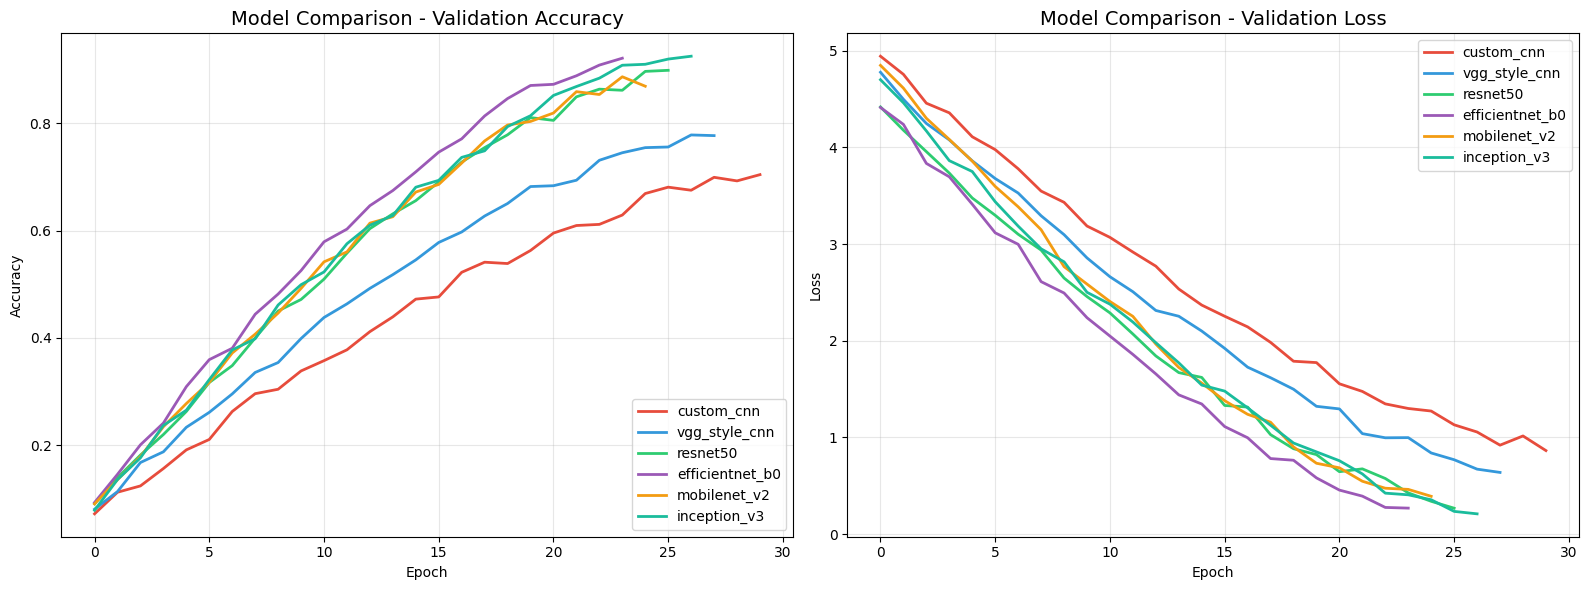

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for idx, (model_name, hist) in enumerate(training_history.items()):
    axes[0].plot(hist['val_accuracy'], label=model_name, color=colors[idx], linewidth=2)
    axes[1].plot(hist['val_loss'], label=model_name, color=colors[idx], linewidth=2)

axes[0].set_title('Model Comparison - Validation Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Model Comparison - Validation Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

In [25]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"{'Model':<20} {'Best Val Acc':<15} {'Best Val Loss':<15} {'Epochs'}")
print("-"*70)

for model_name, hist in training_history.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    epochs = len(hist['val_accuracy'])
    print(f"{model_name:<20} {best_acc:<15.4f} {best_loss:<15.4f} {epochs}")

print("="*70)

best_model = max(training_history.items(), key=lambda x: max(x[1]['val_accuracy']))
print(f"\n🏆 Best Model: {best_model[0]} (Val Accuracy: {max(best_model[1]['val_accuracy']):.4f})")


TRAINING SUMMARY
Model                Best Val Acc    Best Val Loss   Epochs
----------------------------------------------------------------------
custom_cnn           0.7044          0.8639          30
vgg_style_cnn        0.7785          0.6379          28
resnet50             0.8990          0.2678          26
efficientnet_b0      0.9216          0.2685          24
mobilenet_v2         0.8870          0.3907          25
inception_v3         0.9253          0.2093          27

🏆 Best Model: inception_v3 (Val Accuracy: 0.9253)
